Import necessary libraries

In [62]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

Fetch Historical Data from Yahoo Finance

In [64]:
# Define date ranges
in_sample_start = '2010-01-01'
in_sample_end = '2018-12-31'
out_sample_start = '2019-01-01'
out_sample_end = '2023-10-31'

# Fetch SPY data for Turnaround Monday Strategy
data_spy = yf.download('SPY', start=in_sample_start, end=out_sample_end, interval='1d')

# Fetch AAPL data for New Intraday High Strategy
data_aapl = yf.download('AAPL', start=in_sample_start, end=out_sample_end, interval='1d')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Implement Turnaround Monday Strategy

In [66]:
# Prepare SPY data
data_spy['Return'] = data_spy['Close'].pct_change()
data_spy['Day'] = data_spy.index.day_name()
data_spy['Weekday'] = data_spy.index.weekday  # Monday=0, Friday=4

# Identify negative Fridays
data_spy['Friday Negative'] = (data_spy['Return'] < 0) & (data_spy['Weekday'] == 4)
data_spy['Friday Date'] = data_spy.index

# Shift Friday Negative signal to Monday
data_spy['Buy Signal'] = data_spy['Friday Negative'].shift(1)
data_spy['Buy Signal'] = data_spy['Buy Signal'] & (data_spy['Weekday'] == 0)

# Filter Buy Signals
buy_signals = data_spy[data_spy['Buy Signal']]

trades = []

for idx, row in buy_signals.iterrows():
    entry_date = idx
    exit_date = idx + pd.Timedelta(days=3)  # Intended exit date (Monday's close)

    # Adjust for weekends and holidays
    if exit_date not in data_spy.index:
        # Find the next available trading date after exit_date
        exit_date_index = data_spy.index.searchsorted(exit_date, side='left')
        if exit_date_index >= len(data_spy.index):
            # If there is no trading day after exit_date, skip this trade
            continue
        exit_date = data_spy.index[exit_date_index]

    entry_price = data_spy.loc[entry_date]['Close']
    exit_price = data_spy.loc[exit_date]['Close']

    return_pct = (exit_price - entry_price) / entry_price * 100
    trades.append({
        'Entry Date': entry_date,
        'Exit Date': exit_date,
        'Entry Price': entry_price,
        'Exit Price': exit_price,
        'Return (%)': return_pct
    })

df_trades_tam = pd.DataFrame(trades)

Implement New Intraday High Strategy

In [68]:
# Prepare AAPL data
data_aapl['Previous High'] = data_aapl['High'].shift(1)

# Generate Buy Signal: Today's Open > Previous Day's High
data_aapl['Buy Signal'] = data_aapl['Open'] > data_aapl['Previous High']

# Filter Buy Signals
buy_signals_aapl = data_aapl[data_aapl['Buy Signal']]

# Simulate Trades
trades_aapl = []

for idx, row in buy_signals_aapl.iterrows():
    entry_date = idx
    entry_price = row['Open']  # Buy at today's Open
    exit_price = row['Close']  # Sell at today's Close
    return_pct = (exit_price - entry_price) / entry_price * 100
    trades_aapl.append({
        'Entry Date': entry_date,
        'Exit Date': entry_date,
        'Entry Price': entry_price,
        'Exit Price': exit_price,
        'Return (%)': return_pct
    })

df_trades_nih = pd.DataFrame(trades_aapl)


Calculate Performance Metrics

In [121]:
# Turnaround Monday
initial_portfolio_value = 10000
df_trades_tam['Sample'] = np.where(df_trades_tam['Entry Date'] < pd.to_datetime(out_sample_start), 'In-Sample', 'Out-of-Sample')
# Calculate Cumulative Returns
df_trades_tam['Cumulative Return'] = (1 + df_trades_tam['Return (%)']/100).cumprod() * initial_portfolio_value
# Calculate Cumulative Max
df_trades_tam['Cumulative Max'] = df_trades_tam['Cumulative Return'].cummax()

# New Intraday High
df_trades_nih['Sample'] = np.where(df_trades_nih['Entry Date'] < pd.to_datetime(out_sample_start), 'In-Sample', 'Out-of-Sample')
# Calculate Cumulative Returns
df_trades_nih['Portfolio Value'] = initial_portfolio_value * (1 + df_trades_nih['Return (%)'] / 100).cumprod()

df_trades_nih['Cumulative Max'] = df_trades_nih['Cumulative Return'].cummax()


Generate Performance Graphs

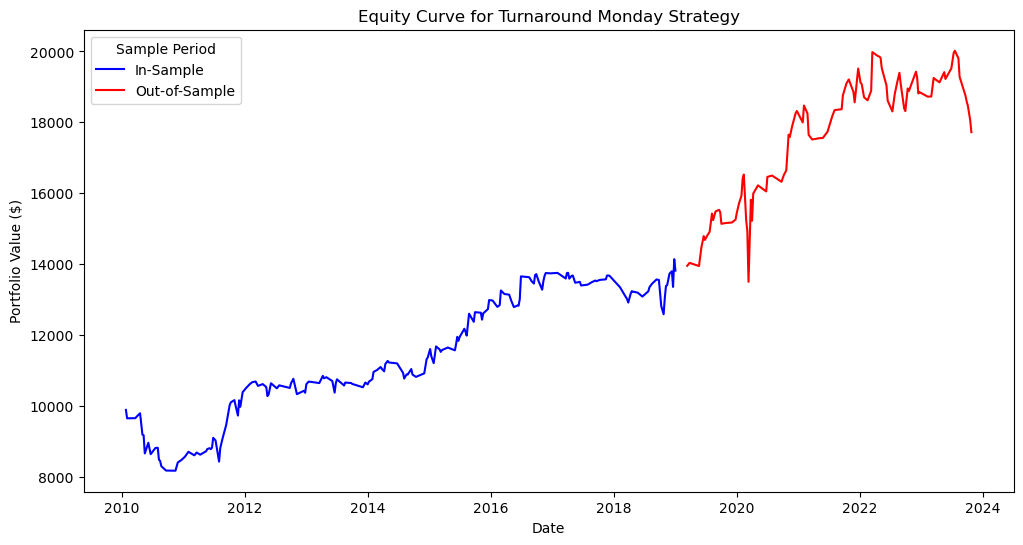

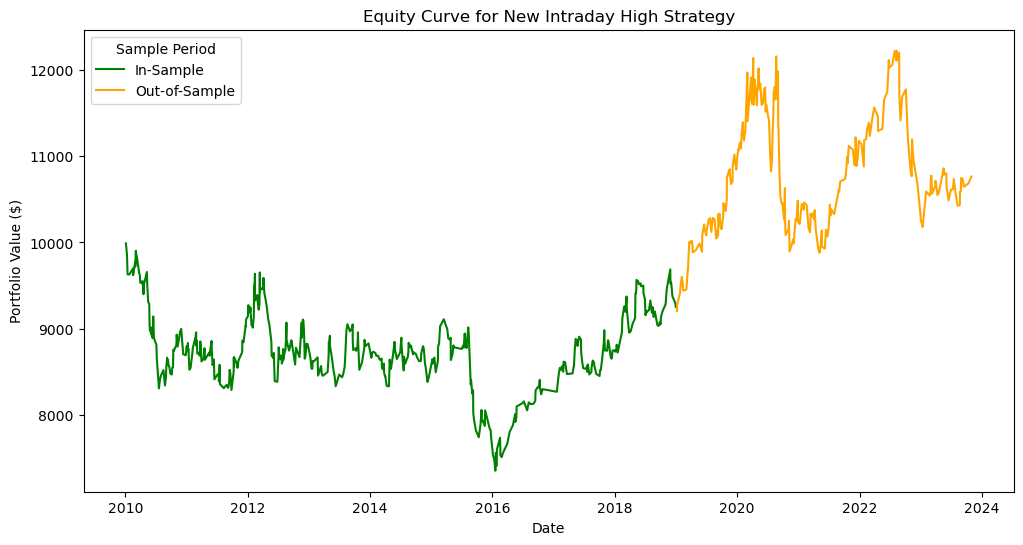

In [117]:
# Equity Curves of Turnaround Monday Strategy
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_trades_tam, x='Entry Date', y='Cumulative Return', hue='Sample', palette=['blue', 'red'])
plt.title('Equity Curve for Turnaround Monday Strategy')
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Date')
plt.legend(title='Sample Period')
# Save the plot
plt.savefig('equity_curve_turnaround_monday.png', dpi=300, bbox_inches='tight')
plt.show()

# Equity Curves of New Intraday High Strategy
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_trades_nih, x='Entry Date', y='Cumulative Return', hue='Sample', palette=['green', 'orange'])
plt.title('Equity Curve for New Intraday High Strategy')
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Date')
plt.legend(title='Sample Period')
# Save the plot
plt.savefig('equity_curve_new_intraday_high.png', dpi=300, bbox_inches='tight')
plt.show()


In [123]:
# Define a function to calculate performance metrics
def calculate_performance_metrics(data, initial_portfolio_value):
    if data.empty:
        return {
            "Final Portfolio Value": 0,
            "Total Trades": 0,
            "Average Return/Trade": 0,
            "Percentage Profitable": 0,
            "Win Rate": 0
        }
    
    final_portfolio_value = data['Portfolio Value'].iloc[-1]
    total_trades = len(data)
    average_return = data['Return (%)'].mean()
    profitable_trades = len(data[data['Return (%)'] > 0])
    win_rate = (profitable_trades / total_trades) * 100 if total_trades > 0 else 0
    
    return {
        "Final Portfolio Value": final_portfolio_value,
        "Total Trades": total_trades,
        "Average Return/Trade": average_return,
        "Percentage Profitable": profitable_trades / total_trades * 100,
        "Win Rate": win_rate
    }

# Function to calculate in-sample and out-of-sample metrics
def generate_performance_summary(df_trades, strategy_name):
    # Split In-Sample and Out-of-Sample data
    in_sample_data = df_trades[df_trades['Entry Date'] < pd.to_datetime(out_sample_start)]
    out_sample_data = df_trades[df_trades['Entry Date'] >= pd.to_datetime(out_sample_start)]

    # Calculate metrics
    in_sample_metrics = calculate_performance_metrics(in_sample_data, initial_portfolio_value=10000)
    out_sample_metrics = calculate_performance_metrics(out_sample_data, initial_portfolio_value=10000)

    # Print the performance summary
    print(f"Performance Summary - {strategy_name} (In-Sample):")
    print(in_sample_metrics)
    
    print(f"\nPerformance Summary - {strategy_name} (Out-of-Sample):")
    print(out_sample_metrics)

    performance_summary = pd.DataFrame({
        "Metric": in_sample_metrics.keys(),
        "In-Sample": in_sample_metrics.values(),
        "Out-of-Sample": out_sample_metrics.values()
    })

    print(f"\nPerformance Summary Table - {strategy_name}:")
    print(performance_summary)
    return performance_summary

# Generate performance summaries for both strategies
print("========== Turnaround Monday Strategy ==========")
summary_tam = generate_performance_summary(df_trades_tam, "Turnaround Monday Strategy")

print("\n========== New Intraday High Strategy ==========")
summary_nih = generate_performance_summary(df_trades_nih, "New Intraday High Strategy")


========== Turnaround Monday Strategy ==========
Performance Summary - Turnaround Monday Strategy (In-Sample):
{'Final Portfolio Value': 13818.868206098397, 'Total Trades': 192, 'Average Return/Trade': 0.1870066233204434, 'Percentage Profitable': 54.166666666666664, 'Win Rate': 54.166666666666664}

Performance Summary - Turnaround Monday Strategy (Out-of-Sample):
{'Final Portfolio Value': 17722.81067371982, 'Total Trades': 102, 'Average Return/Trade': 0.28280175278102726, 'Percentage Profitable': 54.90196078431373, 'Win Rate': 54.90196078431373}

Performance Summary Table - Turnaround Monday Strategy:
                  Metric     In-Sample  Out-of-Sample
0  Final Portfolio Value  13818.868206   17722.810674
1           Total Trades    192.000000     102.000000
2   Average Return/Trade      0.187007       0.282802
3  Percentage Profitable     54.166667      54.901961
4               Win Rate     54.166667      54.901961

========== New Intraday High Strategy ==========
Performance Summa